# n_qubits_QVC_Moons

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split 
from sklearn.datasets import make_blobs 
from sklearn import svm

import scikitplot as skplt

from h import *
from W_unitary import *
from U_unitary import *
from qiskit_algorithms.optimizers import COBYLA, ADAM, SPSA, SLSQP, POWELL, L_BFGS_B, TNC, AQGD

%matplotlib inline
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 100
sns.set()

### helper functions

In [2]:
def make_meshgrid(x1, x2, h=0.2):
    
    x1_min, x1_max = x1.min() - 1, x1.max() + 1
    x2_min, x2_max = x2.min() - 1, x2.max() + 1
    x1x1, x2x2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    
    return x1x1, x2x2


def training_split(X_train, y_train, n_batches):
    
    if len(X_train)%n_batches == 0:
        
        X_batches = np.split(X_train, n_batches)
        y_batches = np.split(y_train, n_batches)
        
    else:
        print('Warning: the training set must be divided into equally sized batches')
    
    return X_batches, y_batches


def k_fold_split(X, y, ele_per_split, i):
    
    k_X_train = np.concatenate( (X[:ele_per_split*i, :], X[ele_per_split*(i+1):, :]) )
    k_X_test = X[ele_per_split*i:ele_per_split*(i+1), :]
    
    k_y_train = np.concatenate( (y[:ele_per_split*i], y[ele_per_split*(i+1):]) )
    k_y_test = y[ele_per_split*i:ele_per_split*(i+1)]
    
    return k_X_train, k_X_test, k_y_train, k_y_test

### dataset

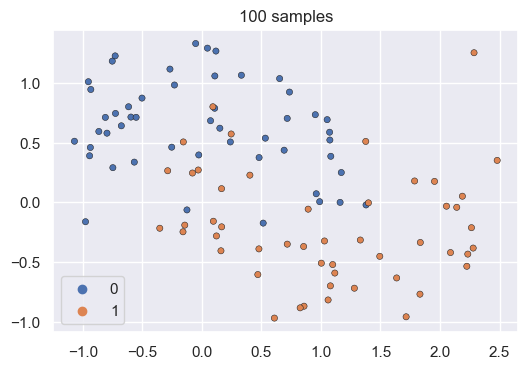

In [3]:
n_samples = 100
X, y = make_moons(n_samples, noise=0.3)

s = 20
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, marker="o", s=s, edgecolor="k", legend=True).set_title(str(n_samples) +" samples")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

n_batches = 7
X_batches, y_batches = training_split(X_train, y_train, n_batches)

## Classical SVM

### linear kernel

In [4]:
linear_kernel = svm.LinearSVC()
linear_kernel.fit(X_train, y_train);

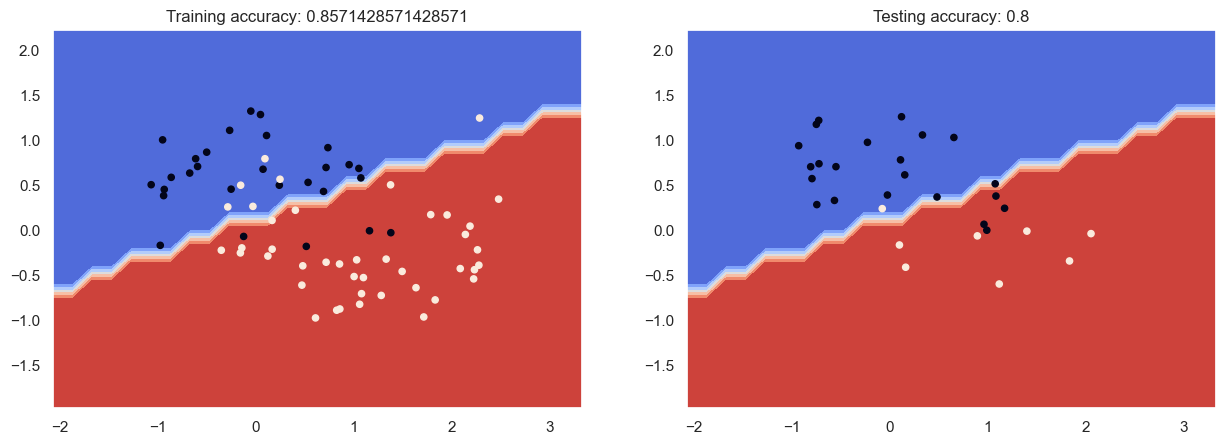

In [5]:
accuracy_train = linear_kernel.score(X_train, y_train)
accuracy_test = linear_kernel.score(X_test, y_test)

X_0, X_1 = X_train[:, 0], X_train[:, 1]
x0x0, x1x1 = make_meshgrid(X_0, X_1)
contours = linear_kernel.predict(np.c_[x0x0.ravel(), x1x1.ravel()])
contours = contours.reshape(x0x0.shape)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[0].scatter(X_0, X_1, s=s, c=y_train)
ax[0].set_title('Training accuracy: '+ str(accuracy_train));

ax[1].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[1].scatter(X_test[:,0], X_test[:,1], s=s, c=y_test)
ax[1].set_title('Testing accuracy: '+ str(accuracy_test));

### gaussian kernel

In [6]:
gaussian_kernel = svm.SVC(gamma = 'scale')
gaussian_kernel.fit(X_train, y_train);

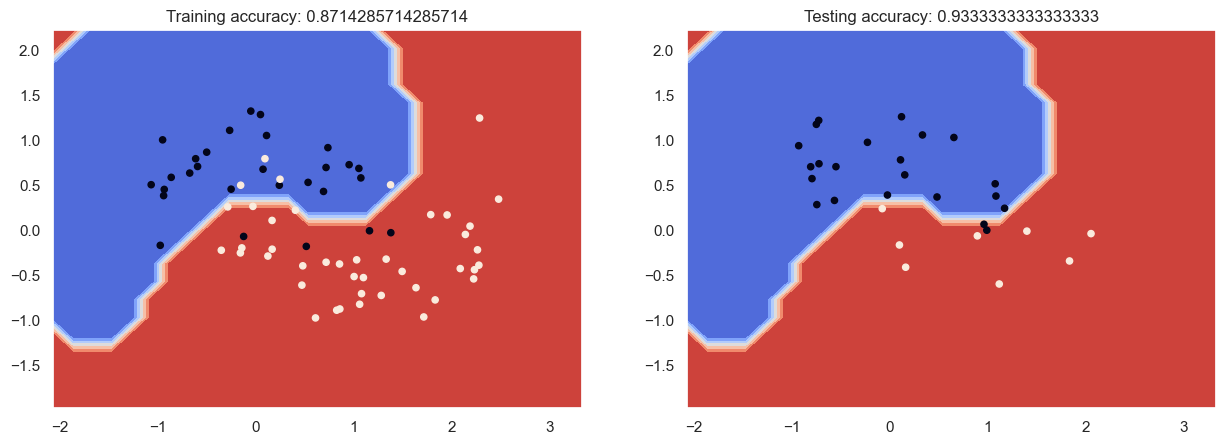

In [7]:
accuracy_train = gaussian_kernel.score(X_train, y_train)
accuracy_test = gaussian_kernel.score(X_test, y_test)

X_0, X_1 = X_train[:, 0], X_train[:, 1]
x0x0, x1x1 = make_meshgrid(X_0, X_1)
contours = gaussian_kernel.predict(np.c_[x0x0.ravel(), x1x1.ravel()])
contours = contours.reshape(x1x1.shape)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[0].scatter(X_0, X_1, s=s, c=y_train)
ax[0].set_title('Training accuracy: '+ str(accuracy_train));

ax[1].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[1].scatter(X_test[:,0], X_test[:,1], s=s, c=y_test)
ax[1].set_title('Testing accuracy: '+ str(accuracy_test));

## Quantum SVM (explicit approach)

In [8]:
RANDOM_STATE = 42
seed = np.random.seed(RANDOM_STATE)

n = 2
d = 2

init_theta = 2*np.pi*np.random.random(n*d*3)
print('Initial parameters: '+ str(init_theta))

Initial parameters: [2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248
 0.3649501  5.44234523 3.77691701 4.44895122 0.12933619 6.09412333]


#### training

In [9]:
def MSE_loss(theta, data, labels):
    
    tmp = []
    for i in range(0, len(labels)):
        if labels[i] == 0:
            tmp.append(-1)
        else:
            tmp.append(1)
    
    predictions = []
    for i in range(0, len(labels)):
        predictions.append(h(data[i], theta, n, d, shots))
    
    error = []
    for i in range(0, len(predictions)):
        parity = predictions[i] - tmp[i]
        error.append(parity)

    norm = np.linalg.norm(error)
    
    return norm

In [10]:
epochs = n_batches
shots = 1024
theta = init_theta
thetas = []
tmp = []
training_accuracies = []
testing_accuracies = []

for i in tqdm(range(0, epochs)):
    
    prediction = []
    data = X_batches[i]
    labels = y_batches[i]
    
    for j in range(0, len(data)):
        prediction.append(h(data[j], theta, n, d, shots))
        
        objective_function = lambda theta: MSE_loss(theta, data, labels)
        optimizer = COBYLA(maxiter=100)
        
        theta_opt = optimizer.minimize(objective_function, theta).x
    
    h_subtest = []
    for k in range(0, len(y_test)):
        h_subtest.append(h(X_test[k], theta, n, d, shots))
    
    train_result = 1 - ( (np.abs(sum(2*labels-1-prediction))/2) / len(labels) )
    test_result = 1 - (np.abs((sum(2*y_test-1-h_subtest)/2)) / len(y_test) )
    training_accuracies.append(train_result)
    testing_accuracies.append(test_result)
    
    thetas.append(theta)
    tmp.append(prediction)
    theta = theta_opt
    


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:51<00:00, 33.11s/it]


In [11]:
print(training_accuracies)
print(np.mean(training_accuracies))
print(testing_accuracies)
print(np.mean(testing_accuracies))

[0.7, 0.6, 0.6, 0.8, 0.8, 0.7, 0.7]
0.7000000000000001
[0.9, 0.9333333333333333, 0.5333333333333333, 0.6333333333333333, 0.5666666666666667, 0.6666666666666667, 0.9666666666666667]
0.7428571428571429


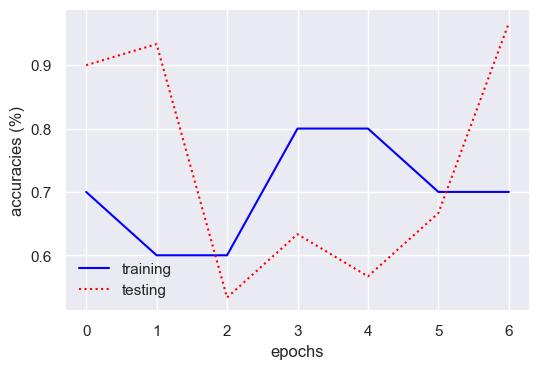

In [12]:
plt.plot(training_accuracies, color='blue', label='training')
plt.plot(testing_accuracies, color='red', linestyle=':',label='testing')
plt.xlabel('epochs')
plt.ylabel('accuracies (%)')
plt.legend(loc=0, frameon=False)
plt.show()

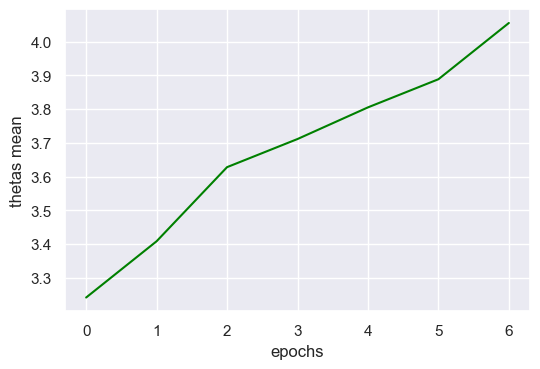

In [13]:
thetas_mean = []

for i in range(len(thetas)):
    thetas_mean.append(np.mean(thetas[i]))
    
plt.plot(thetas_mean, color='green')
plt.xlabel('epochs')
plt.ylabel('thetas mean')
plt.show()

#### testing

In [14]:
predictions = []
for i in range(0, len(tmp)):
    for j in range(0, len(tmp[i])):
        predictions.append(tmp[i][j])

accuracy_train = 1 - ( (np.abs(sum(2*y_train-1-predictions))/2) / len(y_train) )
print('Training accuracy: '+ str(accuracy_train))

Training accuracy: 0.9571428571428572


In [15]:
h_test = []
for i in range(0, len(y_test)):
    h_test.append(h(X_test[i], theta_opt, n, d, shots))

accuracy_test = 1 - (np.abs((sum(2*y_test-1-h_test)/2)) / len(y_test) )
print('Testing accuracy: '+ str(accuracy_test))

Testing accuracy: 0.7666666666666666


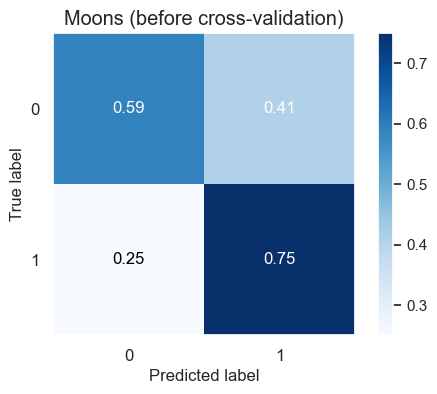

In [16]:
tmp = []
for i in range(0, len(h_test)):
    if h_test[i] == 1:
        tmp.append(0)
    else:
        tmp.append(1)
        
skplt.metrics.plot_confusion_matrix(y_test, tmp, normalize=True, title = 'Moons (before cross-validation)');

### Cross-Validation

In [17]:
k = 4
assert n_samples%k == 0 #check whether k is a divisor of n_samples
ele_per_split = int(n_samples/k)
#for i in range(k):
    #k_X_train, k_X_test, k_y_train, k_y_test = k_fold_split(X, y, ele_per_split, i)
    #print(k_X_train.shape, k_X_test.shape, k_y_train.shape, k_y_test.shape)

In [19]:
theta = init_theta
k_thetas = np.zeros((len(theta), k))
k_training_accuracies = []
k_testing_accuracies = []

for i in tqdm(range(k)):
    
    k_X_train, k_X_test, k_y_train, k_y_test = k_fold_split(X, y, ele_per_split, i)

    objective_function = lambda theta: MSE_loss(theta, k_X_train, k_y_train)
    optimizer = COBYLA(maxiter=100)
    
    theta_opt = optimizer.minimize(objective_function, theta).x

    k_thetas[:, i] = theta_opt

    k_train_predictions = np.zeros(len(k_y_train))
    for j in range(0, len(k_y_train)):
        k_train_predictions[j] = ( h(k_X_train[j], theta_opt, n, d, shots) )

    k_test_predictions = np.zeros(len(k_y_test))
    for j in range(0, len(k_y_test)):
        k_test_predictions[j] = ( h(k_X_test[j], theta_opt, n, d, shots) )
        
    k_train_result = 1 - ( (np.abs(sum(2*k_y_train-1-k_train_predictions))/2) / len(k_y_train) )
    k_test_result = 1 - (np.abs((sum(2*k_y_test-1-k_test_predictions)/2)) / len(k_y_test) )
    k_training_accuracies.append(k_train_result)
    k_testing_accuracies.append(k_test_result)
    
    #training_accuracy = (int(1/2*np.sum(abs(y_optimizer_train-y_train))) / n_samples - n_samples//k) * 100
    #testing_accuracy = (1/2*np.sum(abs(y_optimizer_test-y_test)) / n_samples//k) * 100
    print("Split: ", i+1)
    print("Optimal parameters: ", theta_opt)
    print("Training accuracy: " + str(k_train_result))#int(1/2*np.sum(abs(y_optimizer_train-y_train))), "incorrectly out of ", n_samples - n_samples//k)
    print("Testing accuracy: "+ str(k_test_result))#int(1/2*np.sum(abs(y_optimizer_test-y_test))), "incorrectly out of ", n_samples//k)

 25%|█████████████████████                                                               | 1/4 [00:28<01:26, 28.91s/it]

Split:  1
Optimal parameters:  [2.35335622 6.08026716 4.53416545 3.7614761  0.98024746 0.98013042
 0.36493701 5.44229816 3.776938   4.44892442 0.12933348 6.09411899]
Training accuracy: 0.88
Testing accuracy: 0.88


 50%|██████████████████████████████████████████                                          | 2/4 [00:57<00:57, 28.57s/it]

Split:  2
Optimal parameters:  [2.43756112 5.90950198 4.55195795 4.81234413 1.21010422 2.02002904
 0.24715766 5.35462617 3.85060225 4.63470185 0.25177115 6.09436364]
Training accuracy: 0.96
Testing accuracy: 1.0


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:27<00:29, 29.13s/it]

Split:  3
Optimal parameters:  [2.34941986 5.97423802 4.59918773 4.75964362 0.98051403 0.97803019
 0.36717172 5.44617891 3.77664075 4.45107242 0.12571924 6.09364231]
Training accuracy: 0.9866666666666667
Testing accuracy: 0.76


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:56<00:00, 29.08s/it]

Split:  4
Optimal parameters:  [2.35330935 5.97347532 4.59928038 4.76144973 0.98030794 0.98015873
 0.36497189 5.44231523 3.77691153 4.44890955 0.12930883 7.09417184]
Training accuracy: 0.92
Testing accuracy: 0.96


In [21]:
theta_opt_avg = np.mean(k_thetas, axis=1)
X_val, y_val = make_moons(n_samples//k, noise=0.3)

y_val = 2*y_val-1
y_optimizer_val = np.zeros(len(y_val))
for j in tqdm(range(0, len(y_val))):
    y_optimizer_val[j] = ( h(X_val[j], theta_opt, n, d, shots) )

#validation_accuracy = (1/2*np.sum(abs(y_optimizer_val-y_val)) / n_samples//k) * 100
print("Optimal average parameters: ", theta_opt_avg)
print("Validation accuracy: ", int(1/2*np.sum(abs(y_optimizer_val-y_val))), "incorrectly out of ", n_samples//k)

#print(sum(y_val!=y_optimizer_val))
# print(y_val)
# print(y_optimizer_val)
# print(y_val==y_optimizer_val)

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 223.50it/s]

Optimal average parameters:  [2.37341164 5.98437062 4.57114788 4.5237284  1.03779341 1.2395871
 0.33605957 5.42135462 3.79527313 4.49590206 0.15903318 6.3440742 ]
Validation accuracy:  14 incorrectly out of  25


In [ ]:
X_0, X_1 = X_train[:, 0], X_train[:, 1]
x0x0, x1x1 = make_meshgrid(X_0, X_1)
print(np.c_[x0x0.ravel(), x1x1.ravel()].shape)
#contours = gaussian_kernel.predict(np.c_[x0x0.ravel(), x1x1.ravel()])
contours = np.array(predictions)
contours = contours.reshape(x0x0.shape)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].contourf(x0x0, x1x1, contours, cmap=plt.cm.coolwarm)
ax[0].scatter(X_0, X_1, c=y_train)
ax[0].set_title('Training accuracy: '+ str(accuracy_train));

ax[1].contourf(x0x0, x1x1, new_contours, cmap=plt.cm.coolwarm)
ax[1].scatter(X_test[:,0], X_test[:,1], c=y_test)
ax[1].set_title('Testing accuracy: '+ str(accuracy_test));